In [1]:
import sys
sys.path.append("/mnt/d/repos/github.com/ucsd_capstone/")
from pedtracker import utils

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv
import json

# VIRAT Dataset ---------------------------------------------------------------------------
The VIRAT (Video and Image Retrieval and Analysis Tool) dataset is a publicly available video surveillance dataset for research and development purposes. It was funded by the Defense Advanced Research Projects Agency (DARPA), and it is widely used in the computer vision and machine learning communities for a variety of tasks, such as video surveillance, object detection, tracking, action recognition, and event recognition.

The VIRAT dataset contains realistic video clips captured from multiple cameras in various indoor and outdoor environments, depicting different scenarios, such as crowded scenes, interactions between people and vehicles, and complex activities. The dataset includes over 300 video clips with a total duration of more than 8.5 hours, and it covers a wide range of activities, including normal activities, anomalous events, and various challenges, such as occlusions, lighting changes, and camera motion.

The VIRAT dataset is annotated with ground truth labels, including object bounding boxes, object categories, object attributes, activity labels, and event annotations, making it suitable for training and evaluating computer vision algorithms.

> The VIRAT Video Dataset is designed to be realistic, natural and challenging for video surveillance domains in terms of its resolution, background clutter, diversity in scenes, and human activity/event categories than existing action recognition datasets. It has become a benchmark dataset for the computer vision community.
>
> More info can be found [here](https://viratdata.org/)


### Dataset Attributes
- Realism and natural scenes
	- Uncontrolled
	- Cluttered backgrounds
	- Minimized actors
	- People performing normal actions in standard contexts
- Diversity:
	- Collected in the US
- Quantity
	- Release 2.0 includes videos recorded from 11 scenes captured by HD cameras
	- 30 per action class examples
- Wide range of resolution and frame rates (Spatial and temporal)
	- 2 - 30 Hz frame rates
	- 10-200 pixels per person
	- HD and downsampled data available
- Ground and Aerial videos available
- Categories:
	- Single-object
	- Two-objects
	- Around 12 categories per scene
- Additional annotated videos in MEVA dataset

### Dataset Format
- Scene Directory Format: VIRAT_S_XXYYZZ
- Filename Format: VIRAT_S_XXYYZZ_KK_SSSSSS_TTTTTT.mp4
	- XX: collection group ID 
	- YY: scene ID  
	- ZZ: sequence ID  
	- KK: segment ID (within sequence)  
	- SSSSSS: starting seconds in %06d format. E.g., 1 min 2 sec is 000062.  
	- TTTTTT: ending seconds in %06d format.
- Vehicle categories:
	- Car
	- Bike
	- Vehicle

## Pedestrian Behaviors Covered by VIRAT

| Event | Description | Annotation | Start | End |
|:----- |:----------- |:---------- |:----- |:--- |
| Person loading an Object to a Vehicle | An object moving from a person to a vehicle. The act of 'carrying' should not be included in this event. |  'Person', 'Object' (optional), and 'Vehicle' should be annotated. | The event begins immediately when the cargo to be loaded is “extended” toward the vehicle (i.e., before one's posture changes from one of 'carrying', to one of 'loading.'). | The event ends after the cargo is placed in the vehicle and person-cargo contact is lost. In the event of an occlusion, it ends when the loss of contact is visible.
| Person Unloading an Object from a Vehicle | An object moving from a vehicle to a person. | Annotation: 'Person', 'Object' (optional), and 'Vehicle' should be annotated.| The event begins immediately when the cargo begins to move. If the start of the event is occluded, it begins when the cargo movement is first visible. | The event ends after the cargo is released. If a person, while holding the cargo, begins to walk away from the vehicle, the event ends (at which time the person is 'carrying'). The event also ends if the vehicle drives away while the person is still in contact with the cargo; after the vehicle has been in motion for more than 2 seconds, the person is 'carrying'.
| Person Opening a Vehicle Trunk | A person opening a trunk. A trunk is defined as a container specifically designed to store nonhuman cargo on a vehicle. A trunk need not have a lid (i.e., the back of a pickup truck is a trunk), and it need not open from above (i.e., the back of a van, which opens via double doors, is also a trunk). | 'Person', and 'Vehicle' should be annotated with bounding boxes for as many frames as possible during the event duration. The bbox annotation of 'Trunk' is optional.| The event begins when the trunk starts to move. | The event ends after the trunk has stopped moving.
| Person Closing a Vehicle Trunk | A person closing a trunk. | 'Person', and 'Vehicle' should be annotated with bounding boxes for as many frames as possible during the event duration. The bbox annotation of 'Trunk' is optional. | The event begins when the trunk starts to move. | The event ends after the trunk has stopped moving. |
| Person getting into a Vehicle | A person getting into, or mounting (e.g., a motorcycle), a vehicle. | 'Person', and 'Vehicle' should be annotated.| The event begins when the vehicle's door moves, or, if there is no door, 2s before ½ of the person's body is inside the vehicle. | The event ends when the person is in the vehicle. If the vehicle has a door, the event ends after the door is shut. If not, it ends when the person is in the seated position, or has been inside the vehicle for 2 seconds (whichever comes first). |
| Person getting out of a Vehicle | A person getting out of, or dismounting, a vehicle.| 'Person', and 'Vehicle' should be annotated.| The event begins when the vehicle's door moves. If the vehicle does not have a door, it begins 2 s before ½ of the person's body is outside the vehicle. | The event ends when standing, walking, or running begins.
| Person gesturing | A person gesturing. Gesturing is defined as a movement, usually of the body or limbs, which expresses or emphasizes an idea, sentiment, or attitude. Examples of gesturing include pointing, waving, and sign language.| 'Person' should be annotated. | The event begins when the gesture is evident. For example, when waving, the gesture when the waver begins to raise their arm into the “waving position.” | The event ends when the motion ends |
| Person digging (Note: not existing in Release 2.0) | A person digging. Digging may or may not involve the use of a tool (i.e., digging with one's hands is still considered 'digging'; hands are the tool).| 'Person' should be annotated.| The event begins when the tool makes contact with the ground. | The event ends 5 s after the tool has been removed from the ground, or immediately if the digging tool is dropped.| 
| Person Carrying an Object | A person carrying an object. The object may be carried in either hand, with both hands, or on one's back. Object annotation by bboxes are optional and subject to the difficulty.| 'Person', and 'Object' (optional) are annotated. |  The event begins when the person who will carry the object, makes contact with the object. If someone is carrying an object that is initially occluded, the event begins when the object is visible. |  The event ends when the person is no longer supporting the object against gravity, and contact with the object is broken. In the event of an occlusion, it ends when the loss of contact is visible. |
| Person running | A person running for more than 2s. | 'Person' should be annotated.| When a person is visibly running. |  The event will end 2 s after the person is no longer running. If transitioning to Standing, Walking or Sitting the event will end after after Standing, Walking or Sitting. |
| Person entering a facility | A person entering a facility |  'Person' should be annotated.| The event begins 2 s before that person crosses the facility‘s threshold. | The event ends after the person has completely disappeared from view. |
| Person exiting a facility | A person exiting a facility |  'Person' should be annotated.| The event begins as soon as the person is visible. | The event ends 2 seconds after the person is completely out of the facility| 


## Citation
A Large-scale Benchmark Dataset for Event Recognition in Surveillance Video" by Sangmin Oh, Anthony Hoogs, Amitha Perera, Naresh Cuntoor, Chia-Chih Chen, Jong Taek Lee, Saurajit Mukherjee, J.K. Aggarwal, Hyungtae Lee, Larry Davis, Eran Swears, Xiaoyang Wang, Qiang Ji, Kishore Reddy, Mubarak Shah, Carl Vondrick, Hamed Pirsiavash, Deva Ramanan, Jenny Yuen, Antonio Torralba, Bi Song, Anesco Fong, Amit Roy-Chowdhury, and Mita Desai, in Proceedings of IEEE Comptuer Vision and Pattern Recognition (CVPR), 2011.

# Import Dataset 

In [3]:
data_dir = '/mnt/d/data/virat/'
annotation_dir = data_dir + 'annotations_original/'
video_dir = data_dir + 'videos/'
annotation_cols_dir = '/mnt/d/repos/github.com/ucsd_capstone/pedtracker/virat/'

# Videos ---------------------------------------------------------------------------

# VIRAT Dataset Exploration
### Questions about the Videos: 
- [x] Summary Statistics
    - [x] How many videos are there?
    - [x] Average number of number of frames
    - [x] Distribution of number of frames
- [x] Spatio-Temporal Properties
    - [x] What is the temporal and spatial coverage of the data? 
    - [x] Does the dataset cover a specific time period or multiple time periods? 
- [ ] Limitations
    - [ ] What are the limitations of the dataset? 
    - [ ] Are there any limitations or biases in the data that need to be considered? For example, is the dataset collected from a specific location or population, and may not be representative of broader populations or contexts?
    - [ ] Are there occlusions, lighting changes, camera motion, or other factors that may impact the accuracy or robustness of computer vision algorithms?


In [4]:
videos = []
for i, video in enumerate(os.listdir(video_dir)):
    video_path = video_dir + video
    capture = cv.VideoCapture(video_path)
    fps = capture.get(cv.CAP_PROP_FPS)
    num_frames = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
    duration = int(num_frames/fps)
    videos.append([video.removesuffix('.mp4'), video_path, num_frames, duration])
    capture.release()

videos_df = pd.DataFrame(videos, columns=['name', 'path', 'num_frames', 'duration'])
videos_df.set_index('name', inplace=True)
videos_df.head()

,path,num_frames,duration
name,,,
VIRAT_S_000001,/mnt/d/data/virat/videos/VIRAT_S_000001.mp4,20655,689
VIRAT_S_000002,/mnt/d/data/virat/videos/VIRAT_S_000002.mp4,9075,302
VIRAT_S_000003,/mnt/d/data/virat/videos/VIRAT_S_000003.mp4,20940,698
VIRAT_S_000004,/mnt/d/data/virat/videos/VIRAT_S_000004.mp4,17640,588
VIRAT_S_000006,/mnt/d/data/virat/videos/VIRAT_S_000006.mp4,17805,594


## Summary Statistics

In [5]:
# How many videos are there?
# Average number of number of frames
videos_df.describe()

,num_frames,duration
count,329.000000,329.000000
mean,2653.258359,93.662614
std,3788.204434,125.619994
min,318.000000,13.000000
25%,834.000000,32.000000
50%,1607.000000,59.000000
75%,2691.000000,104.000000
max,29580.000000,986.000000


In [6]:
# Total number of frames in all videos
print(videos_df['num_frames'].sum(), "frames")
print(round(videos_df['duration'].sum() / 60 / 60, 2), "hours of video")

872922 frames
8.56 hours of video


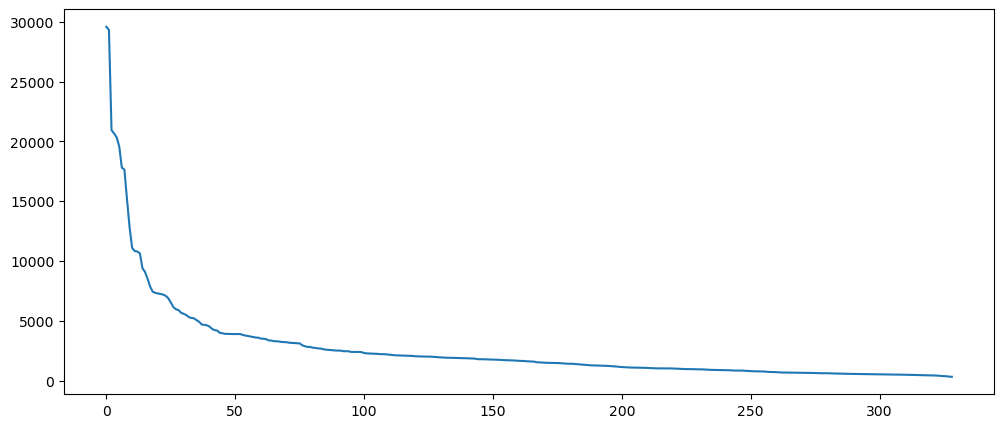

In [7]:
# Distribution of number of frames
plt.figure(figsize=(12,5))
videos_df_sorted = videos_df.sort_values(by='num_frames', ascending=False)
plt.plot(np.arange(len(videos_df_sorted)), videos_df_sorted['num_frames'])

## Spatio-Temporal Properties
### What is the temporal and spatial coverage of the data?
Data was collected at multiple sites distributed throughout the USA. A variety of camera viewpoints and resolutions were included, and actions are performed by many different people. Diverse types of human actions and human-vehicle interactions are included, with a large number of examples (>30) per action class. The dataset is designed to capture these ranges, with 2–30Hz frame rates and 10–200 pixels in person-height.

### Does the dataset cover a specific time period or multiple time periods? 
Seems like the data covers daytime videos, mostly in 

## Limitations
### What are the limitations of the dataset? 

### Are there any limitations or biases in the data that need to be considered? For example, is the dataset collected from a specific location or population, and may not be representative of broader populations or contexts?

### Are there occlusions, lighting changes, camera motion, or other factors that may impact the accuracy or robustness of computer vision algorithms?

# Annotations ---------------------------------------------------------------------------

### Questions about the Annotations: 
- [ ] Outliers
    - [ ] Are there any outliers
    - [x] Are there any missing values?
    - [x] Are there any data quality or integrity issues?
- [ ] Summary and Descriptive Statistics
    - [ ] What is the size and structure of the dataset? 
    - [ ] What are the key variables in the dataset?
    - [ ] Mean, median, mode, standard deviation, and range for each variable?
    - [ ] How many object types are there?
    - [ ] How many objects are shown per video and what type?
    - [ ] Visualize the distribution of "people" in each video
    - [ ] Average size of people objects (calculate area of pixels)
    - [ ] Unique people shown per video? Total number of unique people shown in all videos?
- [ ] Correlations
    - [ ] Are there any relationships or correlations between variables?
- [ ] Limitations
    - [ ] What are the limitations of the annotations? 

## Data Cleaning and Import

In [8]:
# Extend the video dataframe to relate the various annotation files to the videos
videos_df['event_file'] = ''
videos_df['object_file'] = ''
videos_df['mapping_file'] = ''
for index, row in videos_df.iterrows():
    for file in os.listdir(annotation_dir):
        if row.name in file and "events" in file:
            videos_df.loc[index, 'event_file'] = file
        if row.name in file and "objects" in file:
            videos_df.loc[index, 'object_file'] = file
        if row.name in file and "mapping" in file:
            videos_df.loc[index, 'mapping_file'] = file

videos_df.head()

,path,num_frames,duration,event_file,object_file,mapping_file
name,,,,,,
VIRAT_S_000001,/mnt/d/data/virat/videos/VIRAT_S_000001.mp4,20655,689,VIRAT_S_000001.viratdata.events.txt,VIRAT_S_000001.viratdata.objects.txt,VIRAT_S_000001.viratdata.mapping.txt
VIRAT_S_000002,/mnt/d/data/virat/videos/VIRAT_S_000002.mp4,9075,302,VIRAT_S_000002.viratdata.events.txt,VIRAT_S_000002.viratdata.objects.txt,VIRAT_S_000002.viratdata.mapping.txt
VIRAT_S_000003,/mnt/d/data/virat/videos/VIRAT_S_000003.mp4,20940,698,VIRAT_S_000003.viratdata.events.txt,VIRAT_S_000003.viratdata.objects.txt,VIRAT_S_000003.viratdata.mapping.txt
VIRAT_S_000004,/mnt/d/data/virat/videos/VIRAT_S_000004.mp4,17640,588,VIRAT_S_000004.viratdata.events.txt,VIRAT_S_000004.viratdata.objects.txt,VIRAT_S_000004.viratdata.mapping.txt
VIRAT_S_000006,/mnt/d/data/virat/videos/VIRAT_S_000006.mp4,17805,594,VIRAT_S_000006.viratdata.events.txt,VIRAT_S_000006.viratdata.objects.txt,VIRAT_S_000006.viratdata.mapping.txt


Let's find all the videos we have that do NOT have a annotation file connected to it. These files should just be removed from our analysis and training. We may use them for inference, although not having any annotations makes it harder for us to quantify our model performance.

In [9]:
print(len(videos_df[videos_df['event_file']=='']))
print(len(videos_df[videos_df['object_file']=='']))
print(len(videos_df[videos_df['mapping_file']=='']))
print(len(videos_df[videos_df['event_file'].isnull()]))
print(len(videos_df[videos_df['object_file'].isnull()]))
print(len(videos_df[videos_df['mapping_file'].isnull()]))

54
14
54
0
0
0


Seems like we have around 54 videos that do not have an events file associated with it, but there are only 14 that do not have an objects file. For analysis purposes, we can remove all videos that do not have either an events file, or an objects file. We may be able to train on videos that only have an objects file since those videos at least contain the bounding boxes around our subjects, even though we may be missing the subject's "actions". 

In [10]:
videos_df.drop(videos_df[videos_df['event_file']==''].index, inplace=True)
videos_df.drop(videos_df[videos_df['object_file']==''].index, inplace=True)
videos_df.drop(videos_df[videos_df['mapping_file']==''].index, inplace=True)

We are left with 275 videos out of our original 329. That's around 83% of our original set. Now, let's check try opening each file and see if we find any other errors.

In [11]:
# Check to see integrity of all data
videos_error_list = []
for index, row in videos_df.iterrows():
    video_event = annotation_dir + row['event_file']
    video_object = annotation_dir + row['object_file']
    video_mapping = annotation_dir + row['mapping_file']
    
    try:
        video_event = pd.read_csv(video_event, delim_whitespace=True, header=None)
    except:
        print("events file for ", index, " threw an exception")
        videos_error_list.append(index)
    try:
        video_object = pd.read_csv(video_object, delim_whitespace=True, header=None)
    except:
        print("objects file for ", index, " threw an exception")
        videos_error_list.append(index)
    try:
        video_mapping = pd.read_csv(video_mapping, delim_whitespace=True, header=None)
    except:
        print("mapping file for ", index, " threw an exception")
        videos_error_list.append(index)

In [12]:
videos_error_list = set(videos_error_list)
videos_error_list

set()

Looks like there are around 4-5 videos out of our total 275 that have some sort of issue. Let's open up these object files and see what may be happening.

The annotation text files provided by VIRAT dataset seem to contain some encoding errors (see screenshot below). Some manual cleanup will help remove these discrepencies and help load in the data, albeit leaving us with some frames without labels (which is okay). Note: Make sure to archive or save the original, unmodified dataset so you have a backup copy. I have saved the original annotations in the "annotations_original" folder and have saved the modified annotations in the "annotations" folder.

In [41]:
annotation_dir = data_dir + 'annotations/'

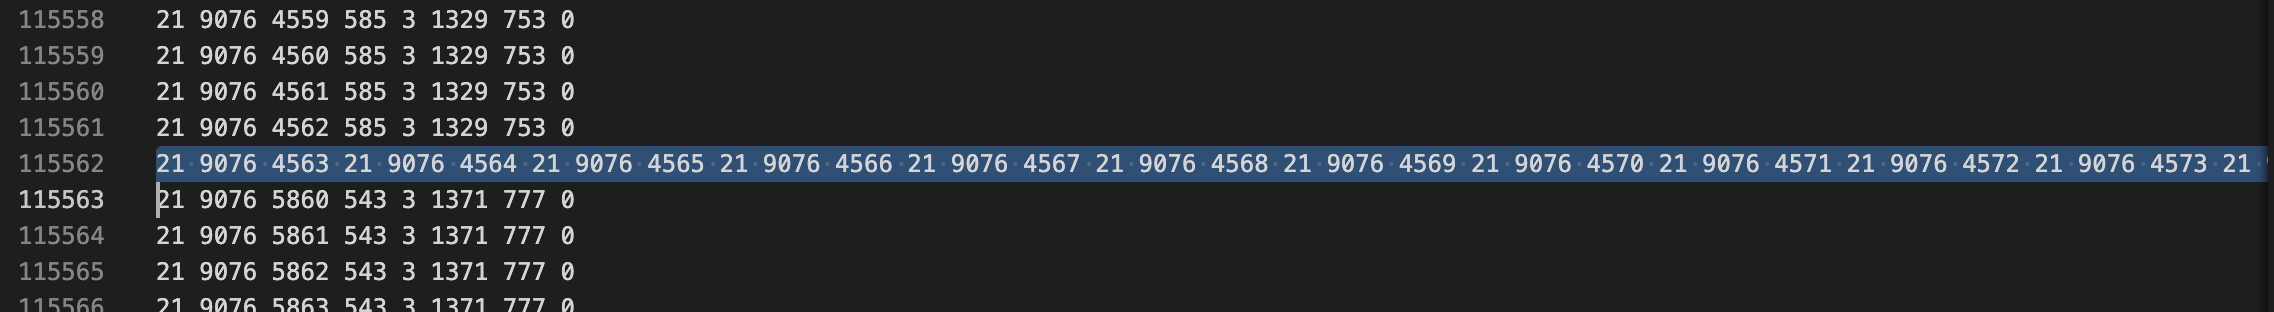

In [42]:
from IPython.display import Image
Image(filename='../assets/virat_dataset_processing.png')

After cleaning up the encoding errors on the 58 or so files, we can re-run our script above to make sure we do not get any encoding errors.

In [43]:
# Check to see integrity of all data
videos_error_list = []
for index, row in videos_df.iterrows():
    video_event = annotation_dir + row['event_file']
    video_object = annotation_dir + row['object_file']
    video_mapping = annotation_dir + row['mapping_file']
    
    try:
        video_event = pd.read_csv(video_event, delim_whitespace=True, header=None)
    except:
        print("events file for ", index, " threw an exception")
        videos_error_list.append(index)
    try:
        video_object = pd.read_csv(video_object, delim_whitespace=True, header=None)
    except:
        print("objects file for ", index, " threw an exception")
        videos_error_list.append(index)
    try:
        video_mapping = pd.read_csv(video_mapping, delim_whitespace=True, header=None)
    except:
        print("mapping file for ", index, " threw an exception")
        videos_error_list.append(index)
videos_error_list = set(videos_error_list)
len(videos_error_list)

0

Looks like we are all set

We will start by just analyzing a single video. This will help us understand the steps involved to create a data analysis pipeline for the entire data. Let's choose an arbitrary video VIRAT_S_000002

In [44]:
## Load data from single annotation files
video = videos_df.iloc[0]
video_event = pd.read_csv(annotation_dir + video['event_file'], delim_whitespace=True, header=None)
video_object = pd.read_csv(annotation_dir + video['object_file'], delim_whitespace=True, header=None)
video_mapping = pd.read_csv(annotation_dir + video['mapping_file'], delim_whitespace=True, header=None)

In [45]:
with open(annotation_cols_dir+'events.json') as json_file:
    events = json.loads(json_file.read())
with open(annotation_cols_dir+'events_type.json') as json_file:
    events_type = json.loads(json_file.read())
with open(annotation_cols_dir+'mapping.json') as json_file:
    mapping = json.loads(json_file.read())
with open(annotation_cols_dir+'objects.json') as json_file:
    objects = json.loads(json_file.read())
with open(annotation_cols_dir+'objects_type.json') as json_file:
    objects_type = json.loads(json_file.read())
    
# To rename our Pandas columns, we need to convert the dictionary keys from String to Int
def dict_key_string_to_int(dictionary):
    dictionary= {int(k):v for k, v in dictionary.items()}
    return dictionary

events = dict_key_string_to_int(events)
events_type = dict_key_string_to_int(events_type)
mapping = dict_key_string_to_int(mapping)
objects = dict_key_string_to_int(objects)
objects_type = dict_key_string_to_int(objects_type)

In [47]:
video_event = video_event.rename(events, axis=1)
video_object = video_object.rename(objects, axis=1)
video_mapping = video_mapping.rename(mapping, axis=1)
print(len(video_event))
video_event.head()

1633


,event_id,event_type,duration,start_frame,end_frame,current_frame,bbox_lefttop_x,bbox_lefttop_y,bbox_width,bbox_height
0,0,1,59,3676,3734,3676,710,454,224,228
1,0,1,59,3676,3734,3677,710,454,224,228
2,0,1,59,3676,3734,3678,710,454,224,228
3,0,1,59,3676,3734,3679,710,454,224,228
4,0,1,59,3676,3734,3680,710,454,224,228


In [48]:
print(len(video_object))
video_object.head()

219982


,object_id,object_duration,current_frame,bbox_lefttop_x,bbox_lefttop_y,bbox_width,bbox_height,object_type
0,1,385,3455,1,663,76,132,1
1,1,385,3456,1,663,76,132,1
2,1,385,3457,1,663,76,132,1
3,1,385,3458,1,663,76,132,1
4,1,385,3459,1,663,76,132,1


In [49]:
print(len(video_mapping))
video_mapping.head()

9


,event_id,event_type,event_duration,start_frame,end_frame,num_obj,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0,1,59,3676,3734,3,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,5,172,3670,3841,2,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,5,217,10413,10629,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2,66,10068,10133,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,6,131,9614,9744,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


From the above we can see that our selected sample video contains 
- 1633 "events" 
- 219,982 "objects"
- 9 mappings

Given this information, let's ask some interesting questions we might want to try and answer regarding this dataset.
Some questions regarding "events" we can try to answer are:
- What types of events have been identified in the selected video?
- What is the frequency of these events in the selected video?
- What is the distribution of these events (which events occur most often in the selected video?)
- At what frames do we see these events occur?
- What are the average durations of different types of events in the selected video?

Other questions regarding the "objects" in the selected video are: 
- What types of objects have been identified in the selected video?
- What is the frequency of these objects in the selected video?
- What is the distribution of these objects (which object occur most often in the selected video?)
- At what frames do we see these objects?
- What are the average durations of different types of objects in the selected video?

We can also try to connect the objects to the events using the "mapping" annotations. 

There are other
- What is the size and structure of the dataset? 
- What are the key variables in the dataset?
- Mean, median, mode, standard deviation, and range for each variable?
- How many object types are there?
- How many objects are shown per video and what type?
- Visualize the distribution of "people" in each video
- Average size of people objects (calculate area of pixels)
- Unique people shown per video? Total number of unique people shown in all videos?

Let's try to see if we can get further insights into our selected video using the questions I have asked above. Later, we can extend this analysis to our entire dataset and see if we can find general patterns in the dataset that may lead to bias.

## Summary and Descriptive Statistics

In [23]:
# What types of events have been identified in the selected video?
# What is the frequency of these events in the selected video?

video_event.replace({"event_type" : events_type}, inplace=False).value_counts('event_type')

event_type
Person carrying an object                        725
Person getting into a Vehicle                    540
Person getting out of a Vehicle                  243
Person Unloading an Object from a Car/Vehicle     66
Person loading an Object to a Vehicle             59
dtype: int64

<BarContainer object of 5 artists>

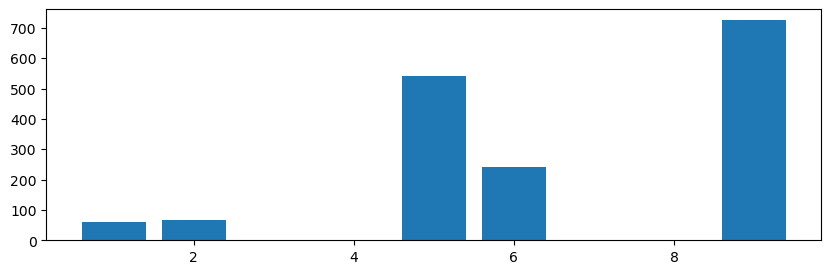

In [24]:
# What is the distribution of these events (which events occur most often in the selected video?)
plt.figure(figsize=(10,3))
plt.bar(x=video_event.value_counts('event_type').index, height=video_event.value_counts('event_type').values)


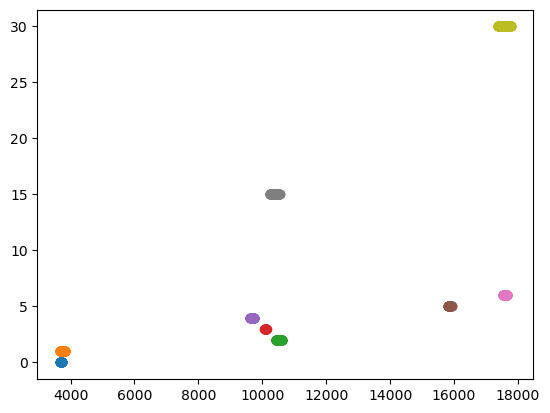

In [25]:
# At what frames do we see these events occur?
events_dict = {}
for i in range(len(video_event)):
    current_event = video_event.iloc[i]
    events_dict[current_event['event_id']] = current_event['start_frame'], current_event['end_frame'], current_event['event_type']

for key in events_dict:
    event_duration = np.arange(events_dict[key][0], events_dict[key][1])
    current_key = [key for i in range(len(event_duration))]
    plt.scatter(event_duration, current_key)

In [26]:
video_object.value_counts('object_type')

object_type
0    123826
1     84008
2     10869
4      1279
dtype: int64

In [27]:
# What types of events have been identified in the selected video?
# What is the frequency of these events in the selected video?

video_object.replace({"object_type" : objects_type}, inplace=False).value_counts('object_type')

object_type
person            123826
car                84008
vehicles           10869
bike, bicycles      1279
dtype: int64

<BarContainer object of 4 artists>

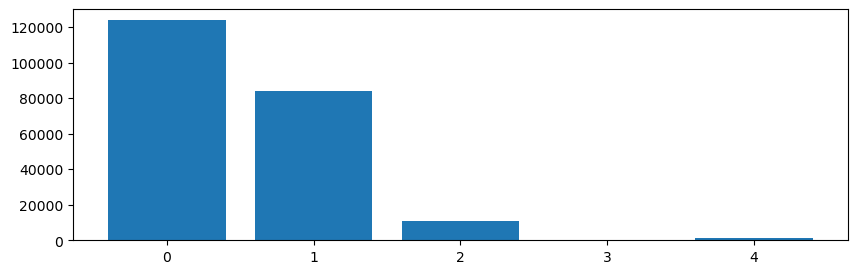

In [28]:
# What is the distribution of these events (which events occur most often in the selected video?)
plt.figure(figsize=(10,3))
plt.bar(x=video_object.value_counts('object_type').index, height=video_object.value_counts('object_type').values)


# Combined Annotations

In [29]:
# Find all objects.txt files for all videos
# Iterate through each person object file and append to existing dataframe

In [30]:
# How many unique people are shown per video?

In [31]:
# Distribution of people objects in each video


In [32]:
# Average size of people objects (calculate area of pixels)


In [33]:
# Unique people objects shown per video? Overall?


## Outliers

In [34]:
# Are there any outliers

## Correlations

In [35]:
# Are there any relationships or correlations between variables?

## Limitations

In [36]:
# What are the limitations of the annotations? 